# Label Studio x Hugging Face datasets hub 

> Using label studio and the Hugging Face datasets hub to iteratively annotate a dataset 

- toc: true 
- badges: false
- comments: true
- categories: [huggingface, huggingface-datasets, annotation, full stack deep learning notes]
- search_exclude: false
- badges: true
- image: https://raw.githubusercontent.com/davanstrien/blog/master/images/huggingface_hub_label_possum.webp

## Full stack deep learning: annotating data

I'm currently going through the [Full Stack Deep Learning course](https://fullstackdeeplearning.com). As part of this we've been going through tools for different parts of the machine learning pipeline. This post talks about data annotation, and how we can combine Label Studio and the [Hugging Face Datasets hub](https://huggingface.co/datasets). I'll use the example of annotating image data for an image classification task. The details of why I'm annotating this data will wait for a future post! 

**note** this post assumes you already know roughly what the Hugging Face Hub is. If you don't [this](https://huggingface.co/course/chapter4/1) is a nice intro.

## What is the goal?

We want to have a way of easily moving from different stages of our machine learning project pipeline. For many projects, especially the weird stuff I'm likely to do, you will need to do some of your own annotating. It almost always makes sense to move quickly between annotating a first batch of data, trying to train a model and iterating. This can help:

- flag issues with your data
- identify if you have ambiguous labels
- help you get some sense of how a model might perform on the task you are working on
- allow you to deploy a model early so you can begin iterating on the whole pipeline 
- ...

<a href="https://imgflip.com/i/6skdh9"><img src="https://i.imgflip.com/6skdh9.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>

This approach can cause some challenges; how do you keep updating your annotations, how can you version the changes?

## A more mundane challenge 

In the full stack deep learning course, one of the [labs](https://fullstackdeeplearning.com/course/2022/lab-6-data-annotation/) covered using [Label Studio](https://labelstud.io/guide/tasks) to annotate data. Label studio is a great open source tool for annotating data across a range of domains and for a variety of tasks. 

Label studio has great support for annotating image data. One challenge we can face, however, is how to load images into label studio. This can be particularly tricky if you only have the images locally since label studio prefers images to be available via a URL. There are [various ways around this](https://labelstud.io/guide/tasks.html#Import-data-from-a-local-directory) but we may also be able to tackle this challenge using the datasets hub. 


We'll start by downloading a dataset we want annotate **warning** this dataset is pretty big ~44GB uncompressed. 

In [ ]:
%%bash
wget https://nlsfoundry.s3.amazonaws.com/data/nls-data-encyclopaediaBritannica.zip
unzip *.zip

We'll import some standard libraries

In [89]:
import pandas as pd
from pathlib import Path

## Create a new dataset on the Hub 
Since we want to upload our data to the Hugging Face hub we'll create a new dataset on the Hugging Face Hub via the CLI.

```bash
huggingface-cli repo create encyclopaedia_britannica --type dataset 
```

Under the hood, Hugging Face hub datasets (and models) are Git repositories. We'll clone this repo and move the downloaded dataset into this new Git repository.

```bash
git clone https://huggingface.co/datasets/davanstrien/encyclopaedia_britannica
mv nls-data-encyclopaediaBritannica encyclopaedia_britannica/

```

Since the number of examples in this dataset is beyond what we're likely to annotate we do a bit of deleting of the dataset. You could also take a sample of the original but in this case I'm happy to reclaim some space on my hardrive! 

In [92]:
import shutil
from tqdm.auto import tqdm

first we get rid of some alto folders that we don't need for the dataset we're aiming to create

In [94]:
for directory in tqdm(
    list(
        (
            Path("encyclopaedia_britannica/nls-data-encyclopaediaBritannica").rglob(
                "*alto"
            )
        )
    )
):
    shutil.rmtree(directory)

100%|██████████| 195/195 [00:34<00:00,  5.62it/s]


there are a few other `*.xml` files in this dataset we also remove

In [95]:
for xml_file in tqdm(
    list(
        (
            Path("encyclopaedia_britannica/nls-data-encyclopaediaBritannica").rglob(
                "*xml"
            )
        )
    )
):
    xml_file.unlink()

100%|██████████| 195/195 [00:00<00:00, 1464.47it/s]


Let's take a look at how many images we have now

In [103]:
image_files = list(
    (Path("encyclopaedia_britannica/nls-data-encyclopaediaBritannica").rglob("*jpg"))
)

In [97]:
len(image_files)

155388

We're not likely to annotate this many images, let's aim to have a max of 10,000 images. This is also likely to be more than we'll annotate but we may use a smaller sample for unsupervised pre-training. 

In [104]:
num_to_remove = len(image_files) - 10_000

We'll now randomly remove the extra images we don't need beyond our sample

In [105]:
import random

In [106]:
to_remove = random.sample(image_files, num_to_remove)
for file in tqdm(to_remove):
    file.unlink()

100%|██████████| 90000/90000 [00:33<00:00, 2659.02it/s]


In [107]:
len(
    list(
        (
            Path("encyclopaedia_britannica/nls-data-encyclopaediaBritannica").rglob(
                "*jpg"
            )
        )
    )
)

10000

### Uploading our raw data to the hub 

We can now upload this data to the Hugging Face Hub. Under the hood the Hub uses Git so everything you love (and hate) about Git should be familiar. The main difference between using the hub and GitHub or another Git hosting platform is that the Hugging Face hub has support for large files. This means we can more easily work with large files (like our images). 

```bash
cd encyclopaedia_britannica
git lfs track "*.jpg"
git add .gitattributes
git add nls-data-encyclopaediaBritannica
git commit -m "add image files"
git push
```

## Loading local files and metadata 

The particular dataset we're working with also has a metadata file associated with it. We can  grab all of the images so we can put them in a DataFrame and merge this with metadata about these images. We may not use this extra metadata but it's nice to have this additional metadata about our items alongside our annotations. This can help us debug where our model is performing badly later on. 

In [108]:
image_files = list(
    Path("encyclopaedia_britannica/nls-data-encyclopaediaBritannica").rglob("*.jpg")
)

In [109]:
df = pd.DataFrame(image_files, columns=["filename"])

This dataset also comes with some metadata. We'll load that in to another DataFrame

In [110]:
metadata_df = pd.read_csv(
    "encyclopaedia_britannica/nls-data-encyclopaediaBritannica/encyclopaediaBritannica-inventory.csv",
    header=None,
    names=["id", "meta"],
    dtype={"id": "int64"},
)

In [111]:
df["id"] = df.filename.apply(lambda x: x.parts[-3]).astype("int64")

In [112]:
df = df.merge(metadata_df, on="id")
df

,filename,id,meta
0,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291,"Encyclopaedia Britannica - Third edition, Volu..."
1,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291,"Encyclopaedia Britannica - Third edition, Volu..."
2,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291,"Encyclopaedia Britannica - Third edition, Volu..."
3,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291,"Encyclopaedia Britannica - Third edition, Volu..."
4,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291,"Encyclopaedia Britannica - Third edition, Volu..."
...,...,...,...
9995,encyclopaedia_britannica/nls-data-encyclopaedi...,193696083,"Encyclopaedia Britannica - Seventh edition, Vo..."
9996,encyclopaedia_britannica/nls-data-encyclopaedi...,193696083,"Encyclopaedia Britannica - Seventh edition, Vo..."
9997,encyclopaedia_britannica/nls-data-encyclopaedi...,193696083,"Encyclopaedia Britannica - Seventh edition, Vo..."
9998,encyclopaedia_britannica/nls-data-encyclopaedi...,193696083,"Encyclopaedia Britannica - Seventh edition, Vo..."


## Annotating using label studio 

Now we have our images uploaded to the Hugging Face hub, how we go about annotating? As was mentioned already the Hugging Face hub is essentially a Git repo. Since we uploaded our image files individually i.e. not in a compressed folder, we can access each file from that repo. We mentioned before that label studio can load images from URLs. The hub has an API that we can use to interact with our repository. Let's see how we can use this to get our data ready for label studio.

In [113]:
from huggingface_hub import list_repo_files, hf_hub_url

In [114]:
files = list_repo_files("davanstrien/encyclopaedia_britannica", repo_type="dataset")
files[:2]

['.gitattributes',
 'nls-data-encyclopaediaBritannica/144133901/image/188082865.3.jpg']

We'll filter out some data we are not interested in annotating

In [116]:
files = [file for file in files if not file.startswith(".")]
len(files)

10002

`hf_hub_url` can be used to generate the URL for a particular file

In [117]:
hf_hub_url(
    "davanstrien/encyclopaedia_britannica",
    "192866824.3.jpg",
    subfolder="sample/nls-data-encyclopaediaBritannica/192547788/image",
    repo_type="dataset",
)

'https://huggingface.co/datasets/davanstrien/encyclopaedia_britannica/resolve/main/sample/nls-data-encyclopaediaBritannica/192547788/image/192866824.3.jpg'

We can use this to grab all of the URLs we're interested in 

In [118]:
urls = []
for file in files:
    file = Path(file)
    urls.append(
        hf_hub_url(
            "davanstrien/encyclopedia_britannica",
            file.name,
            subfolder=file.parents[0],
            repo_type="dataset",
        )
    )

We can now load these into a DataFrame, and save this to a CSV file. 

In [121]:
pd.DataFrame(urls, columns=["image"]).to_csv("data.csv", index=False)

In [122]:
pd.read_csv("data.csv")

,image
0,https://huggingface.co/datasets/davanstrien/en...
1,https://huggingface.co/datasets/davanstrien/en...
2,https://huggingface.co/datasets/davanstrien/en...
3,https://huggingface.co/datasets/davanstrien/en...
4,https://huggingface.co/datasets/davanstrien/en...
...,...
9997,https://huggingface.co/datasets/davanstrien/en...
9998,https://huggingface.co/datasets/davanstrien/en...
9999,https://huggingface.co/datasets/davanstrien/en...
10000,https://huggingface.co/datasets/davanstrien/en...


### Loading annotations into label studio 

We can use this file to load our data into label studio
![Label Studio import](https://raw.githubusercontent.com/davanstrien/blog/master/images/label-studio-import.webp)


From here, we need to define our annotation task. We can then begin annotating data. 

### Export annotations 

You can either wait until you've finished doing all the labels, however, we may have a lot of data to annotate so it's likely instead that we will want to export once we've either hit a reasonable number of labels or get too bored of annotating. There are various different export formats available in this case we'll use JSON-Min

![](https://raw.githubusercontent.com/davanstrien/blog/master/images/label-studio-export.webp)

### Load annotations

Now we have export our annotations lets load them into a new DatafFame. We'll only select the columns we're interested in

In [123]:
annotation_dataframe = pd.read_json("project-3-at-2022-09-08-15-16-4279e901.json")[
    ["image", "choice"]
]

In [124]:
annotation_dataframe

,image,choice
0,https://huggingface.co/datasets/davanstrien/en...,text-only
1,https://huggingface.co/datasets/davanstrien/en...,text-only
2,https://huggingface.co/datasets/davanstrien/en...,text-only
3,https://huggingface.co/datasets/davanstrien/en...,text-only
4,https://huggingface.co/datasets/davanstrien/en...,text-only
...,...,...
1516,https://huggingface.co/datasets/davanstrien/en...,text-only
1517,https://huggingface.co/datasets/davanstrien/en...,text-only
1518,https://huggingface.co/datasets/davanstrien/en...,text-only
1519,https://huggingface.co/datasets/davanstrien/en...,text-only


If we take a look at the URL for one of the annotations, you'll see that we still have a nice path that mirrors the folder structure of the original data. This also means we can merge this annotations DataFrame with our previous metadata DataFrame.

In [125]:
annotation_dataframe.loc[0, "image"]

'https://huggingface.co/datasets/davanstrien/encyclopaedia_britannica/resolve/main/nls-data-encyclopaediaBritannica/192693396/image/192979378.3.jpg'

In [126]:
annotation_dataframe.loc[0, "image"].split("/")[-4:]

['nls-data-encyclopaediaBritannica', '192693396', 'image', '192979378.3.jpg']

In [127]:
annotation_dataframe["filename"] = annotation_dataframe["image"].apply(
    lambda x: "/".join(x.split("/")[-4:])
)

In [128]:
annotation_dataframe["filename"] = annotation_dataframe["filename"].astype(str)

In [129]:
df = df.merge(annotation_dataframe, on="filename", how="outer")

In [130]:
df

,filename,id,meta,image,choice
0,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291.0,"Encyclopaedia Britannica - Third edition, Volu...",NaN,NaN
1,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291.0,"Encyclopaedia Britannica - Third edition, Volu...",NaN,NaN
2,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291.0,"Encyclopaedia Britannica - Third edition, Volu...",NaN,NaN
3,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291.0,"Encyclopaedia Britannica - Third edition, Volu...",NaN,NaN
4,encyclopaedia_britannica/nls-data-encyclopaedi...,190273291.0,"Encyclopaedia Britannica - Third edition, Volu...",NaN,NaN
...,...,...,...,...,...
11516,nls-data-encyclopaediaBritannica/144133901/ima...,NaN,NaN,https://huggingface.co/datasets/davanstrien/en...,text-only
11517,nls-data-encyclopaediaBritannica/144133901/ima...,NaN,NaN,https://huggingface.co/datasets/davanstrien/en...,text-only
11518,nls-data-encyclopaediaBritannica/144133901/ima...,NaN,NaN,https://huggingface.co/datasets/davanstrien/en...,text-only
11519,nls-data-encyclopaediaBritannica/144133901/ima...,NaN,NaN,https://huggingface.co/datasets/davanstrien/en...,text-only


This means we can keep our nice orignal metadata intact but also add our additional metadata where it exists. Let's check how many annotations we have

In [131]:
df.choice.value_counts()

text-only      1436
illustrated      70
Name: choice, dtype: int64

We can also see how much of our dataset we have coverage for

In [132]:
len(df[df.choice.notna()]) / len(df)

0.13071781963371235

### How to use our annotations?  

We now have some annoations inside a DataFrame. What should we do we these? We can also use the Hub for storing this. This comes with a few benefits:
- we keep our data and annotations in the same place. 
- since the Hub uses Git under the hood we also get versioning for our dataset. We can use this version information to track for example how different models perform during training as we add more labels. 

Another nice thing about the Hub is that we can create dataset loading scripts to load our data. This script can use this CSV we've just created and only load the data we have examples for.

First we'll save to a CSV file:

In [133]:
df.to_csv("annotations.csv", index=None)

We can then copy these into the same repository used to host our dataset. 

```bash
cp annotations.csv encyclopedia_britannica/
```

Once we've done this we can commit these and push our annotations to the hub:

```bash
cd encyclopedia_britannica/
git add annotations.csv
git commit -m "update annotations"
git push
```

## What next?

We now have a repository which contains a bunch of images, and a CSV file which contains annotations for some of these images. How do we use this for model training? From this point we can create a dataset [loading script](https://huggingface.co/docs/datasets/dataset_script) inside the same repository. 

This dataset loading script will allow us to load the data from the hub using the `datasets` library. Additionally we can write this script so that it only loads data we have annotations for. 

What does this mean:
- we have a dataset we can use to train our model
- the dataset is hosted on the Hugging Face hub which means it's easy to share with other people 
- we can keep adding new annotations to this dataset and pushing our changes to the hub 
- Since the `datasets` library has nice caching support it will only download the dataset if there are changes. This change will be triggered by changes to our annotations.csv file. 



## Loading the dataset 

Once we have our loading script we can load our annotations using the `datasets` library:

In [23]:
from datasets import load_dataset
import datasets

In [26]:
ds = load_dataset('davanstrien/encyclopedia_britannica')

Using custom data configuration default
Reusing dataset encyclopedia_britannica (/Users/dvanstrien/.cache/huggingface/datasets/davanstrien___encyclopedia_britannica/default/1.1.0/8dd4d7982f31fd11ed71020b79b4b11a0068c8243080066e43b9fe3980934467)


  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
ds['train'][0]

{'metadata': 'nan',
 'image': 'https://huggingface.co/datasets/davanstrien/encyclopaedia_britannica/resolve/main/nls-data-encyclopaediaBritannica/192693396/image/192979378.3.jpg',
 'label': 0}

In [13]:
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
from functools import partial
from concurrent.futures import ThreadPoolExecutor
import urllib
import io
import PIL

USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=1, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image"]))
    return batch


In [14]:
num_threads = 16
ds = ds.map(fetch_images, batched=True, batch_size=64, fn_kwargs={"num_threads": num_threads}, writer_batch_size=64)

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/encyclopaedia_britannica/default/1.1.0/f7fb8d1f26daa72fbaf883bb1707e13d304414c1af16f02c00782c985971f87c/cache-fda9502ac5b20332.arrow


In [18]:
ds = ds.cast_column('image', datasets.Image())

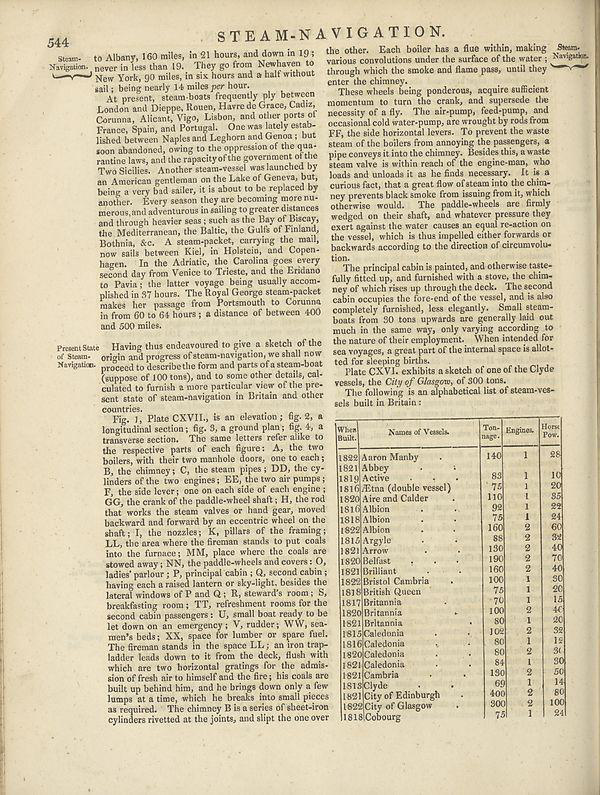

In [19]:
ds['train'][0]['image']

## Where won't this work? 

This workflow is based on the assumption that the dataset you are annotating is public from the start. This is usually possible for the domain I work in (libraries) but could be a major blocker for other people. This workflow might also break if you have lots of people annotating. There are probably ways around this but things could start becoming a bit hacky...

The loading script for loading this dataset does some slightly strange things to avoid loading images that don't yet have annotations. I think it would make sense to rework this script if you get to a point you are unlikely to do any more annotations. 